# Assignment 2: recommender System

## Code from the lecture

In [1]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('../../DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('../../DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../../DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [53]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]
    
R_train, R_test = train_test_split(R,test_size = 0.1)

In [3]:
epsilon=0.0000001 
def CosineDist(a,b):
    return a.dot(b)/(np.linalg.norm(a)*np.linalg.norm(b)+epsilon) #added epsilon for numerical stability: avoiding div by zero -> NaN

In [4]:
def EucledianDist(a,b):
    return np.linalg.norm(a-b)

In [54]:
%%time
#again, implementation not efficient: better use lamda opperators 
D_train=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_train[i,j]=CosineDist(R_train[:,i],R_train[:,j])

CPU times: user 1min 10s, sys: 19.8 ms, total: 1min 10s
Wall time: 1min 10s


In [55]:
%%time
#again, implementation not efficient: better use lamda opperators 
D_train_Eucl=np.zeros((np.shape(movies)[0],np.shape(movies)[0]))
for i in range(0,np.shape(movies)[0]):
    for j in range(0,np.shape(movies)[0]):
        if i!=j:
            D_train_Eucl[i,j]=EucledianDist(R_train[:,i],R_train[:,j])

CPU times: user 46.9 s, sys: 19.9 ms, total: 46.9 s
Wall time: 46.9 s


In [33]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getRandN(movie_id, D, N=5):
    return np.random.randint(0,D[movie_id,:].shape[0],N)

def getTopRatedN(R,N=5):
    #meanRates = R.mean(axis=1)
    return (np.argsort(np.mean(R,axis=0))[-5:]).tolist()

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title, D, R, Sys):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        if(Sys == 0):
            return getNameByID(getTopN(getIDbyName(title),D))[::-1]
        elif(Sys == 1):
            return getNameByID(getRandN(getIDbyName(title),D))[::-1]
        elif(Sys == 2):
            return getNameByID(getTopRatedN(R))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test, R, Sys):
    #print ("Hit Scores for: ", getNameByID(ID))
    if(Sys == 0):
        res_id = getTopN(ID,D)[::-1]
        res_title = getNameByID(getTopN(ID,D))[::-1]
        res_score = Test[res_id]
    elif(Sys == 1):
        res_id = getRandN(ID,D)[::-1]
        res_title = getNameByID(getRandN(ID,D))[::-1]
        res_score = Test[res_id]
    elif(Sys == 2):
        res_id = getTopRatedN(R)[::-1]
        res_title = getNameByID(getTopRatedN(R))[::-1]
        res_score = Test[res_id]
            
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test,R_train,Sys):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i],R_train,Sys)
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [56]:
CII("Star",D_train,R_train,0)

recommending movies for: 'Star Wars (1977)'


180          Return of the Jedi (1983)
173     Raiders of the Lost Ark (1981)
171    Empire Strikes Back, The (1980)
0                     Toy Story (1995)
120      Independence Day (ID4) (1996)
Name: title, dtype: object

In [57]:
np.mean(test_Score(D_train,R_test,R_train,0))

2.1393684210526316

## Score with Eucledian Distance

In [58]:
CII("Star",D_train_Eucl,R_train,0)

recommending movies for: 'Star Wars (1977)'


989                 Anna Karenina (1997)
1061       Four Days in September (1997)
1126             Truman Show, The (1998)
937           Smile Like Yours, A (1997)
1293    Ayn Rand: A Sense of Life (1997)
Name: title, dtype: object

In [59]:
np.mean(test_Score(D_train_Eucl,R_test,R_train,0))

1.4366315789473683

## Random Recommedation

In [60]:
CII("Star",D_train,R_train,1)

recommending movies for: 'Star Wars (1977)'


762             Happy Gilmore (1996)
1453     Angel and the Badman (1947)
339             Boogie Nights (1997)
1515        Wedding Gift, The (1994)
386     Age of Innocence, The (1993)
Name: title, dtype: object

In [61]:
np.mean(test_Score(D_train,R_test,R_train,1))

0.19452631578947369

## Top 5 Movies

In [62]:
CII("Star",D_train,R_train,2)

recommending movies for: 'Star Wars (1977)'


49              Star Wars (1977)
99                  Fargo (1996)
180    Return of the Jedi (1983)
257               Contact (1997)
126        Godfather, The (1972)
Name: title, dtype: object

In [73]:
np.mean(test_Score(D_train,R_test,R_train,2))

2.0715789473684207

## SVD

In [64]:
U,S,V = np.linalg.svd(D_train)

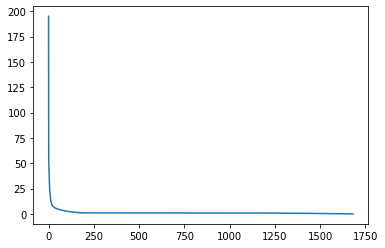

In [65]:
fig, axes = plt.subplots()
axes.plot(S)

In [68]:
threshold = 0.01
mask = S > S.max()*threshold
mask.sum()

130

In [69]:
D_reconst=np.dot(U[:,:mask.sum()]*S[mask],V[:mask.sum(),:])

In [72]:
np.mean(test_Score(D_reconst,R_test,R_train,0))

2.7919999999999994

## Ergebnisse

Cosine Distance:      2,14
Euclediuan Dist:      1,43
Random Recomendation: 0,19
Top 5 Recommendation: 2,07
SVD:                  2,79

Man kann sehen, dass der SVD Ansatz die besten Ergebnisse liefert.
Überaschend ist, dass das Empfehlen der 5 best Bewerteten Filme ein fast so gutes Ergebniss liefert wie mit der Cosinus Distanz
Zudem ist zu sehen, dass die Cosinus Distanz bessere ergebnisse liefert, wie die Euclidische Distanz.

# 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the ressults.

## 4.2 Baseline Results
Implement and compare results of two very simple baseline methods 
* random recommendations: randomly recommend 5 movies (HINT user np.random sub-library to generate random movie IDs)
* always recommending the top 5 movies: HINT: need to find the IDs of the top 5 movies over all users first

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $D$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct and evaluate $D'$
